In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(x):
    return x * (1 - x)


def tanh(x):
    return 2 / (1 + np.exp(-2 * x)) - 1


def dtanh(x):
    return 1 - x ** 2


def precision_recall(y_true, y_pred) -> tuple:
    num_classes = y_true.shape[1]
    precisions = []
    recalls = []

    for class_index in range(num_classes):
        true_positive = np.sum((y_true[:, class_index] == 1) & (np.argmax(y_pred, axis=1) == class_index))
        predicted_positive = np.sum(np.argmax(y_pred, axis=1) == class_index)
        actual_positive = np.sum(y_true[:, class_index] == 1)

        if predicted_positive == 0:
            precisions.append(0)
        else:
            precisions.append(true_positive / predicted_positive)

        if actual_positive == 0:
            recalls.append(0)
        else:
            recalls.append(true_positive / actual_positive)

    return precisions, recalls



def F1(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    precisions, recalls = precision_recall(y_true, y_pred)
    f1_scores = []
    for precision, recall in zip(precisions, recalls):
        if precision + recall == 0:
            f1_scores.append(0)
        else:
            f1_scores.append(2 * (precision * recall) / (precision + recall))
    return np.mean(f1_scores)


def draw_roc_curve(y_true: np.ndarray, y_pred: np.ndarray):
    num_classes = y_true.shape[1]
    all_fpr = []
    all_tpr = []

    plt.figure()
    for class_index in range(num_classes):
        fpr, tpr = roc(y_true[:, class_index], y_pred[:, class_index])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='Class {} (AUC = {:.2f})'.format(class_index, roc_auc))
        interpolated_tpr = np.interp(np.linspace(0, 1, 100), fpr, tpr)
        all_fpr.append(np.linspace(0, 1, 100))
        all_tpr.append(interpolated_tpr)

    mean_tpr = np.mean(all_tpr, axis=0)
    mean_fpr = np.linspace(0, 1, 100)

    plt.plot(mean_fpr, mean_tpr, label='Micro-average ROC', color='deeppink', linestyle='--')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()


def roc(y_true, y_pred):
    threshold_values = sorted(set(y_pred), reverse=True)
    tpr_values = [0]
    fpr_values = [0]
    num_positive = np.sum(y_true)
    num_negative = len(y_true) - num_positive

    for threshold in threshold_values:
        y_pred_binary = np.where(y_pred >= threshold, 1, 0)
        true_positives = np.sum((y_pred_binary == 1) & (y_true == 1))
        false_positives = np.sum((y_pred_binary == 1) & (y_true == 0))
        tpr = true_positives / num_positive
        fpr = false_positives / num_negative
        tpr_values.append(tpr)
        fpr_values.append(fpr)

    return fpr_values, tpr_values


def auc(fpr, tpr):
    auc_value = 0
    for i in range(1, len(fpr)):
        auc_value += (fpr[i] - fpr[i - 1]) * tpr[i]
    return auc_value


class Lay:
    def __init__(self, activation='relu'):
        self.activation = None
        if activation == 'relu':
            self.activation = ReLU()
        elif activation == 'softmax':
            self.activation = Softmax()
        else:
            self.activation = None

    def forward(self, input_data):
        pass

    def backward(self, d_output, learning_rate):
        pass


class RNN(Lay):
    def __init__(self, input_size, output_size, return_sequence=False, activation='relu'):
        super().__init__(activation)
        self.input_size = input_size
        self.hidden_size = input_size
        self.output_size = output_size
        self.return_sequence = return_sequence
        self.ws = 0.2

        self.input_data = None
        self.hiddens = None

        self.input_weights = None
        self.hidden_weights = None
        self.output_weights = None
        self.hidden_bias = None
        self.output_bias = None

        if self.input_size is not None:
            self._init_weights()

    def _init_weights(self):
        self.input_weights = np.random.uniform(-self.ws, self.ws, size=(self.input_size, self.hidden_size))
        self.hidden_weights = np.random.uniform(-self.ws, self.ws, size=(self.hidden_size, self.hidden_size))
        self.output_weights = np.random.uniform(-self.ws, self.ws, size=(self.hidden_size, self.output_size))
        self.hidden_bias = np.zeros(self.hidden_size)
        self.output_bias = np.zeros(self.output_size)

    def forward(self, input_data):
        if self.input_size is None:
            self.input_size = input_data.shape[-1]
            self._init_weights()

        self.input_data = input_data
        batch_size, sequence_length, _ = input_data.shape
        hidden = np.zeros((batch_size, self.hidden_size))
        self.hiddens = np.zeros((batch_size, sequence_length, self.hidden_size))

        input_x = np.dot(input_data, self.input_weights)
        for i in range(sequence_length):
            hidden = input_x[:, i, :] + np.dot(hidden, self.hidden_weights) + self.hidden_bias
            hidden = tanh(hidden)
            self.hiddens[:, i, :] = hidden

        if self.return_sequence:
            output = np.dot(self.hiddens, self.output_weights) + self.output_bias
        else:
            final_hidden_state = self.hiddens[:, -1, :]
            output = np.dot(final_hidden_state, self.output_weights) + self.output_bias

        return output

    def backward(self, d_out, learning_rate):
        batch_size, sequence_length, _ = self.input_data.shape

        input_weights_gradient = np.zeros_like(self.input_weights)
        hidden_weights_gradient = np.zeros_like(self.hidden_weights)
        output_weights_gradient = np.zeros_like(self.output_weights)
        output_bias_gradient = np.zeros_like(self.output_bias)
        hidden_bias_gradient = np.zeros_like(self.hidden_bias)

        hidden_error_gradient = np.zeros((batch_size, self.hidden_size))

        d_in = np.zeros_like(self.input_data)

        for i in reversed(range(sequence_length)):
            hidden_i = self.hiddens[:, i, :]

            if self.return_sequence:
                l_grad_i = d_out[:, i, :]
                output_weights_gradient += np.dot(hidden_i.T, l_grad_i)
                output_bias_gradient += np.mean(l_grad_i, axis=0)

                hidden_error = np.dot(l_grad_i, self.output_weights.T) + hidden_error_gradient
            else:
                if i == sequence_length - 1:
                    l_grad_i = d_out
                    output_weights_gradient += np.dot(hidden_i.T, l_grad_i)
                    output_bias_gradient += np.mean(l_grad_i, axis=0)

                    hidden_error = np.dot(l_grad_i, self.output_weights.T)
                else:
                    hidden_error = hidden_error_gradient

            hidden_derivative = dtanh(hidden_i)
            h_grad_i = hidden_derivative * hidden_error

            if i > 0:
                hidden_weights_gradient += np.dot(self.hiddens[:, i - 1, :].T, h_grad_i)
                hidden_bias_gradient += np.mean(h_grad_i, axis=0)

            input_x = self.input_data[:, i, :]
            input_weights_gradient += np.dot(input_x.T, h_grad_i)

            hidden_error_gradient = np.dot(h_grad_i, self.hidden_weights.T)

            d_in[:, i, :] = np.dot(h_grad_i, self.input_weights.T)

        # update weights
        self.input_weights -= learning_rate * input_weights_gradient / batch_size
        self.hidden_weights -= learning_rate * hidden_weights_gradient / batch_size
        self.output_weights -= learning_rate * output_weights_gradient / batch_size
        self.hidden_bias -= learning_rate * hidden_bias_gradient / batch_size
        self.output_bias -= learning_rate * output_bias_gradient / batch_size

        return d_in


class DenseLay(Lay):
    def __init__(self, input_size=None, output_size=10, activation='relu'):
        super().__init__(activation)
        self.ws = 0.2
        self.x = None
        self.weights = None
        self.output_size = output_size
        if input_size is not None:
            self.weights = np.random.randn(input_size, output_size) * self.ws
        self.bias = np.zeros((1, output_size))

    def forward(self, x):
        if self.weights is None:
            input_size = x.shape[-1]
            self.weights = np.random.randn(input_size, self.output_size) * self.ws

        self.x = x
        output_data = np.dot(x, self.weights) + self.bias
        return output_data

    def backward(self, d_out, learning_rate):
        dx = np.dot(d_out, self.weights.T)
        dw = np.dot(self.x.T, d_out)
        db = np.sum(d_out, axis=0)
        self.weights -= learning_rate * dw
        self.bias -= learning_rate * db
        return dx


class ReLU:
    def __init__(self):
        super().__init__()
        self.output_data = None

    def forward(self, input_data: np.ndarray) -> np.ndarray:
        self.output_data = np.maximum(0, input_data)
        return self.output_data

    def backward(self, d_output: np.ndarray, **kwargs) -> np.ndarray:
        return d_output * (self.output_data > 0)


class Softmax:
    def __init__(self):
        super().__init__()
        self.output_data = None

    def forward(self, input_data: np.ndarray) -> np.ndarray:
        exp_values = np.exp(input_data - np.max(input_data, axis=-1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=-1, keepdims=True)
        self.output_data = probabilities
        return self.output_data

    def backward(self, d_output: np.ndarray, **kwargs) -> np.ndarray:
        return d_output


class CategoricalCrossEntropy:
    def __call__(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        epsilon = 1e-15
        clipped_y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.sum(y_true * np.log(clipped_y_pred)) / y_pred.shape[0]

    def gradient(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        epsilon = 1e-15
        clipped_y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -(y_true - clipped_y_pred) / y_pred.shape[0]


class Model:
    def __init__(self, loss_function, learning_rate, epochs):
        self.layers = []
        self.loss_function = loss_function
        self.learning_rate = learning_rate
        self.epochs = epochs

    def add_lay(self, lay: Lay):
        self.layers.append(lay)
        if lay.activation is not None:
            self.layers.append(lay.activation)
        return self

    def forward(self, input_data: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            input_data = layer.forward(input_data)
        return input_data

    def backward(self, d_output, learning_rate) -> None:
        for layer in reversed(self.layers):
            d_output = layer.backward(d_output, learning_rate=learning_rate)

    def train(self, x_train_data, y_train_data, learning_rate,
              batch_size=24, epochs=50) -> None:

        data_size = len(x_train_data)
        for epoch in range(epochs):
            indices = np.random.permutation(data_size)
            x_train_data_shuffled = x_train_data[indices]
            y_train_data_shuffled = y_train_data[indices]

            mean_loss_train = 0.0
            for batch_start in range(0, data_size, batch_size):
                batch_end = min(batch_start + batch_size, data_size)
                x_batch = x_train_data_shuffled[batch_start:batch_end]
                y_batch = y_train_data_shuffled[batch_start:batch_end]

                predictions_train = self.forward(x_batch)
                mean_loss_train += self.loss_function(y_batch, predictions_train)
                d_output_train = self.loss_function.gradient(y_batch, predictions_train)
                self.backward(d_output_train, learning_rate)

    def predict(self, x_test: np.ndarray) -> np.ndarray:
        return self.forward(x_test)


class LSTM(Lay):
    def __init__(self, input_size, output_size, return_sequence=False, activation='relu'):
        super().__init__(activation)
        self.input_size = input_size
        self.hidden_size = input_size
        self.output_size = output_size
        self.return_sequence = return_sequence
        self.ws = 0.3

        self.x = None
        self.hs = None
        self.cs = None
        self.os = None
        self.fs = None
        self.ins = None
        self._cs = None
        self.c_tanh = None

        if self.input_size is not None:
            self._init_weights()

    def _init_weights(self):
        self.Wi = np.random.uniform(-self.ws, self.ws, (self.input_size, self.hidden_size))  # noqa
        self.Ui = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.hidden_size))
        self.bi = np.zeros(self.hidden_size)

        self.Wf = np.random.uniform(-self.ws, self.ws, (self.input_size, self.hidden_size))
        self.Uf = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.hidden_size))
        self.bf = np.zeros(self.hidden_size)

        self.Wo = np.random.uniform(-self.ws, self.ws, (self.input_size, self.hidden_size))
        self.Uo = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.hidden_size))
        self.bo = np.zeros(self.hidden_size)

        self.Wc = np.random.uniform(-self.ws, self.ws, (self.input_size, self.hidden_size))
        self.Uc = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.hidden_size))
        self.bc = np.zeros(self.hidden_size)

        self.Wy = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.output_size))
        self.by = np.zeros(self.output_size)

    def forward(self, x):
        if self.input_size is None:
            self.input_size = x.shape[-1]
            self._init_weights()

        batch_size, sequence_length, _ = x.shape
        self.x = x

        ht = np.zeros((batch_size, self.hidden_size))
        ct = np.zeros((batch_size, self.hidden_size))

        self.hs = np.zeros((batch_size, sequence_length, self.hidden_size))
        self.cs = np.zeros((batch_size, sequence_length, self.hidden_size))
        self.ins = np.zeros((batch_size, sequence_length, self.hidden_size))
        self.os = np.zeros((batch_size, sequence_length, self.hidden_size))
        self.fs = np.zeros((batch_size, sequence_length, self.hidden_size))
        self._cs = np.zeros((batch_size, sequence_length, self.hidden_size))
        self.c_tanh = np.zeros((batch_size, sequence_length, self.hidden_size))

        for t in range(sequence_length):
            xt = x[:, t, :]
            it = sigmoid(xt @ self.Wi + ht @ self.Ui + self.bi)
            ft = sigmoid(xt @ self.Wf + ht @ self.Uf + self.bf)
            ot = sigmoid(xt @ self.Wo + ht @ self.Uo + self.bo)
            _c = tanh(xt @ self.Wc + ht @ self.Uc + self.bc)

            self.ins[:, t, :] = it
            self.os[:, t, :] = ot
            self.fs[:, t, :] = ft
            self._cs[:, t, :] = _c

            ct = ft * ct + it * _c
            self.cs[:, t, :] = ct

            self.c_tanh[:, t, :] = tanh(ct)
            ht = ot * self.c_tanh[:, t, :]
            self.hs[:, t, :] = ht

        if self.return_sequence:
            output = self.hs @ self.Wy + self.by
        else:
            final_hidden_state = self.hs[:, -1, :]
            output = final_hidden_state @ self.Wy + self.by

        return output

    def backward(self, dY, learning_rate):
        batch_size, sequence_length, _ = self.x.shape

        dWi, dUi, dbi = np.zeros_like(self.Wi), np.zeros_like(self.Ui), np.zeros_like(self.bi)
        dWf, dUf, dbf = np.zeros_like(self.Wf), np.zeros_like(self.Uf), np.zeros_like(self.bf)
        dWo, dUo, dbo = np.zeros_like(self.Wo), np.zeros_like(self.Uo), np.zeros_like(self.bo)
        dWc, dUc, dbc = np.zeros_like(self.Wc), np.zeros_like(self.Uc), np.zeros_like(self.bc)
        dWy, dby = np.zeros_like(self.Wy), np.zeros_like(self.by)

        dh_next = np.zeros((batch_size, self.hidden_size))
        dc_next = np.zeros((batch_size, self.hidden_size))

        dX = np.zeros((batch_size, sequence_length, self.input_size))

        for t in reversed(range(sequence_length)):
            dy = dY[:, t, :] if self.return_sequence else (dY if t == sequence_length - 1 else np.zeros_like(dY))

            dWy += self.hs[:, t, :].T @ dy
            dby += np.sum(dy, axis=0)
            dh = dy @ self.Wy.T + dh_next
            dc = self.os[:, t, :] * dh * dtanh(self.cs[:, t, :]) + dc_next
            dot = dsigmoid(self.os[:, t, :]) * self.c_tanh[:, t, :] * dh

            if t > 0:
                dft = self.cs[:, t - 1, :] * dc * dsigmoid(self.fs[:, t, :])
            else:
                dft = np.zeros_like(self.fs[:, t, :])

            dit = self._cs[:, t, :] * dc * dsigmoid(self.ins[:, t, :])
            dct = self.ins[:, t, :] * dc * dtanh(self._cs[:, t, :])
            dWi += self.x[:, t, :].T @ dit
            dbi += np.sum(dit, axis=0)

            dWf += self.x[:, t, :].T @ dft
            dbf += np.sum(dft, axis=0)

            dWo += self.x[:, t, :].T @ dot
            dbo += np.sum(dot, axis=0)

            dWc += self.x[:, t, :].T @ dct
            dbc += np.sum(dct, axis=0)

            if t > 0:
                dUi += self.hs[:, t - 1, :].T @ dit
                dUf += self.hs[:, t - 1, :].T @ dft
                dUo += self.hs[:, t - 1, :].T @ dot
                dUc += self.hs[:, t - 1, :].T @ dct

            dh_next = dit @ self.Ui.T + dft @ self.Uf.T + dot @ self.Uo.T + dct @ self.Uc.T
            dc_next = self.fs[:, t, :] * dc

            dX[:, t, :] = dit @ self.Wi.T + dft @ self.Wf.T + dot @ self.Wo.T + dct @ self.Wc.T

        self.Wi -= learning_rate * dWi / batch_size
        self.Ui -= learning_rate * dUi / batch_size
        self.bi -= learning_rate * dbi / batch_size
        self.Wf -= learning_rate * dWf / batch_size
        self.Uf -= learning_rate * dUf / batch_size
        self.bf -= learning_rate * dbf / batch_size
        self.Wo -= learning_rate * dWo / batch_size
        self.Uo -= learning_rate * dUo / batch_size
        self.bo -= learning_rate * dbo / batch_size
        self.Wc -= learning_rate * dWc / batch_size
        self.Uc -= learning_rate * dUc / batch_size
        self.bc -= learning_rate * dbc / batch_size
        self.Wy -= learning_rate * dWy / batch_size
        self.by -= learning_rate * dby / batch_size

        return dX


class GRU(Lay):
    def __init__(self, input_size, output_size, return_sequence=False, activation='relu'):
        super().__init__(activation)
        self.input_size = input_size
        self.hidden_size = input_size
        self.output_size = output_size
        self.return_sequence = return_sequence
        self.ws = 0.3

        self.x = None
        self.z = None
        self.r = None
        self.h = None
        self.h_hat = None

        if self.input_size is not None:
            self._init_weights()

    def _init_weights(self):
        # Weight matrices for update gate
        self.Wz = np.random.uniform(-self.ws, self.ws, (self.input_size, self.hidden_size))  # noqa
        self.Uz = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.hidden_size))
        self.bz = np.zeros(self.hidden_size)

        # Weight matrices for reset gate
        self.Wr = np.random.uniform(-self.ws, self.ws, (self.input_size, self.hidden_size))
        self.Ur = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.hidden_size))
        self.br = np.zeros(self.hidden_size)

        # Weight matrices for candidate hidden state
        self.Wh = np.random.uniform(-self.ws, self.ws, (self.input_size, self.hidden_size))
        self.Uh = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.hidden_size))
        self.bh = np.zeros(self.hidden_size)

        # Weight matrices for output layer
        self.Wy = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.output_size))
        self.by = np.zeros(self.output_size)

    def forward(self, x):
        if self.input_size is None:
            self.input_size = x.shape[-1]
            self._init_weights()

        batch_size, sequence_length, _ = x.shape
        self.x = x

        h = np.zeros((batch_size, sequence_length, self.hidden_size))
        z = np.zeros((batch_size, sequence_length, self.hidden_size))
        r = np.zeros((batch_size, sequence_length, self.hidden_size))
        h_hat = np.zeros((batch_size, sequence_length, self.hidden_size))

        for t in range(sequence_length):
            prev_h = h[:, t - 1, :] if t > 0 else np.zeros_like(h[:, 0, :])
            # Compute the update gate
            z[:, t, :] = sigmoid(x[:, t, :] @ self.Wz + prev_h @ self.Uz + self.bz)

            # Compute the reset gate
            r[:, t, :] = sigmoid(x[:, t, :] @ self.Wr + prev_h @ self.Ur + self.br)

            # Compute the candidate hidden state
            h_hat[:, t, :] = tanh(x[:, t, :] @ self.Wh + (r[:, t, :] * prev_h) @ self.Uh + self.bh)

            # Compute the current hidden state
            h[:, t, :] = z[:, t, :] * prev_h + (1 - z[:, t, :]) * h_hat[:, t, :]

        self.z = z
        self.r = r
        self.h = h
        self.h_hat = h_hat

        if self.return_sequence:
            o_t = self.h @ self.Wy + self.by
            return o_t

        o_t = self.h[:, -1, :] @ self.Wy + self.by
        return o_t

    def backward(self, dY, learning_rate=0.01):
        batch_size, sequence_length, _ = self.x.shape  # noqa

        # Initialize gradients
        dWz, dUz, dbz = np.zeros_like(self.Wz), np.zeros_like(self.Uz), np.zeros_like(self.bz)
        dWr, dUr, dbr = np.zeros_like(self.Wr), np.zeros_like(self.Ur), np.zeros_like(self.br)
        dWh, dUh, dbh = np.zeros_like(self.Wh), np.zeros_like(self.Uh), np.zeros_like(self.bh)
        dWy, dby = np.zeros_like(self.Wy), np.zeros_like(self.by)

        dh_next = np.zeros((batch_size, self.hidden_size))

        dX = np.zeros((batch_size, sequence_length, self.input_size))

        for t in reversed(range(sequence_length)):
            dy = dY[:, t, :] if self.return_sequence else (dY if t == sequence_length - 1 else np.zeros_like(dY))

            dWy += self.h[:, t, :].T @ dy
            dby += np.sum(dy, axis=0)

            # Intermediary derivatives
            dh = dy @ self.Wy.T + dh_next
            dh_hat = np.multiply(dh, (1 - self.z[:, t, :]))
            dh_hat_l = dh_hat * dtanh(self.h_hat[:, t, :])

            # ∂loss/∂Wh, ∂loss/∂Uh and ∂loss/∂bh
            dWh += np.dot(self.x[:, t, :].T, dh_hat_l)
            dUh += np.dot(np.multiply(self.r[:, t, :], self.h[:, t - 1, :]).T, dh_hat_l)
            dbh += np.sum(dh_hat_l, axis=0)

            # Intermediary derivatives
            drhp = np.dot(dh_hat_l, self.Uh.T)
            dr = np.multiply(drhp, self.h[:, t - 1, :])
            dr_l = dr * dsigmoid(self.r[:, t, :])

            # ∂loss/∂Wr, ∂loss/∂Ur and ∂loss/∂br
            dWr += np.dot(self.x[:, t, :].T, dr_l)
            dUr += np.dot(self.h[:, t - 1, :].T, dr_l)
            dbr += np.sum(dr_l, axis=0)

            # Intermediary derivatives
            dz = np.multiply(dh, self.h[:, t - 1, :] - self.h_hat[:, t, :])
            dz_l = dz * dsigmoid(self.z[:, t, :])

            # ∂loss/∂Wz, ∂loss/∂Uz and ∂loss/∂bz
            dWz += np.dot(self.x[:, t, :].T, dz_l)
            dUz += np.dot(self.h[:, t - 1, :].T, dz_l)
            dbz += np.sum(dz_l, axis=0)

            # All influences of previous layer to loss
            dh_fz_inner = np.dot(dz_l, self.Uz.T)
            dh_fz = np.multiply(dh, self.z[:, t, :])
            dh_fhh = np.multiply(drhp, self.r[:, t, :])
            dh_fr = np.dot(dr_l, self.Ur.T)

            # ∂loss/∂h𝑡₋₁
            dh_next = dh_fz_inner + dh_fz + dh_fhh + dh_fr

            dX[:, t, :] = dz_l @ self.Wz.T + dr_l @ self.Wr.T + dh_hat_l @ self.Wh.T

        # Update weights and biases
        self.Wz -= learning_rate * dWz / batch_size  # noqa
        self.Uz -= learning_rate * dUz / batch_size
        self.bz -= learning_rate * dbz / batch_size
        self.Wr -= learning_rate * dWr / batch_size
        self.Ur -= learning_rate * dUr / batch_size
        self.br -= learning_rate * dbr / batch_size
        self.Wh -= learning_rate * dWh / batch_size
        self.Uh -= learning_rate * dUh / batch_size
        self.bh -= learning_rate * dbh / batch_size
        self.Wy -= learning_rate * dWy / batch_size
        self.by -= learning_rate * dby / batch_size

        return dX


def split(x_data, y_data, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    indices = np.arange(len(x_data))
    np.random.shuffle(indices)

    test_samples = int(len(x_data) * test_size)

    test_indices = indices[:test_samples]
    train_indices = indices[test_samples:]

    if isinstance(x_data, pd.DataFrame):
        x_train_data, x_test_data = x_data.iloc[train_indices], x_data.iloc[test_indices]
    elif isinstance(x_data, np.ndarray):
        x_train_data, x_test_data = x_data[train_indices], x_data[test_indices]
    else:
        raise ValueError("Unsupported type for 'x'. Use pandas DataFrame or NumPy array.")

    if isinstance(y_data, pd.Series):
        y_train_data, y_test_data = y_data.iloc[train_indices], y_data.iloc[test_indices]
    elif isinstance(y_data, np.ndarray):
        y_train_data, y_test_data = y_data[train_indices], y_data[test_indices]
    else:
        raise ValueError("Unsupported type for 'y'. Use pandas Series or NumPy array.")

    return x_train_data, x_test_data, y_train_data, y_test_data




In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('Steel_industry_data.csv')

In [3]:
data['date'] = pd.to_datetime(data['date'], dayfirst=True)
data.sort_values(by='date', inplace=True)

data['day'] = data['date'].dt.weekday
data['month'] = data['date'].dt.month
data['time'] = data['date'].dt.time
data = data.drop(columns=['date', 'WeekStatus', 'Day_of_week'])

In [4]:
data['TimeStamp'] = data['time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
data = data.drop(columns=['time'])


In [5]:
from sklearn.preprocessing import LabelEncoder

scaler = StandardScaler()
numeric_features = ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                    'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'TimeStamp']
data[numeric_features] = scaler.fit_transform(data[numeric_features])

label_encoder = LabelEncoder()
data['Load_Type'] = label_encoder.fit_transform(data['Load_Type'])

x = data.drop(columns='Load_Type').values
y = pd.get_dummies(data['Load_Type']).values

seq_len = 7
X_seq = []
Y_seq = []

for i in range(len(x) - seq_len):
    X_seq.append(x[i:i + seq_len])
    Y_seq.append(y[i + seq_len])

X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)

x_train, x_test, y_train, y_test = split(X_seq, Y_seq, test_size=0.1, random_state=42)

In [6]:

from matplotlib import pyplot as plt

def plot_roc_auc(y_test, y_pred):
    precisions, recalls = precision_recall(y_test, y_pred)
    target_names = [f'Load class {i}' for i in range(len(precisions))]
    for i, class_name in enumerate(target_names):
        print("{:<20} Precision:{:<10.4f} Recall:{:<10.4f}".format(class_name, precisions[i], recalls[i]))

    f1_score = F1(y_test, y_pred)
    print(f"F1 mean score: {f1_score}")

    num_classes = y_test.shape[1]
    all_fpr = []
    all_tpr = []

    plt.figure(figsize=(9, 6))
    for class_index in range(num_classes):
        fpr, tpr = roc(y_test[:, class_index], y_pred[:, class_index])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='Class {} (AUC = {:.2f})'.format(class_index, roc_auc))
        interpolated_tpr = np.interp(np.linspace(0, 1, 100), fpr, tpr)
        all_fpr.append(np.linspace(0, 1, 100))
        all_tpr.append(interpolated_tpr)

    plt.plot([0, 1], [0, 1], color='navy', linestyle='-')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

Load class 0         Precision:0.9367     Recall:0.9742    
Load class 1         Precision:0.5949     Recall:0.1541    
Load class 2         Precision:0.5594     Recall:0.8315    
F1 mean score: 0.6228791641624917


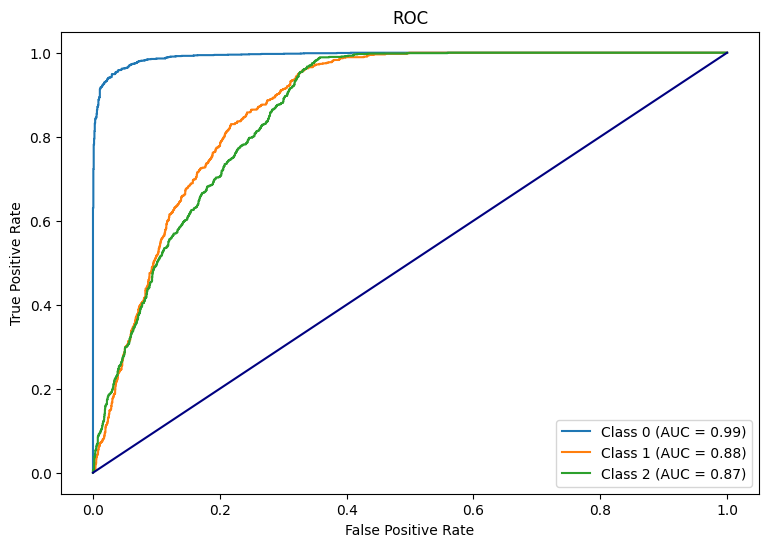

In [7]:


sequence_length = 4
learning_rate = 0.03
epochs = 10

model = Model(CategoricalCrossEntropy(), learning_rate=learning_rate, epochs=epochs)
model.add_lay(RNN(input_size=x_test.shape[-1], output_size=24, return_sequence=True))
model.add_lay(RNN(input_size=24, output_size=10, return_sequence=False))
model.add_lay(DenseLay(10, 3, activation='softmax'))

model.train(x_train, y_train,learning_rate=learning_rate, epochs=epochs)

y_pred = model.predict(x_test)
y_pred_r = y_pred
y_test_r = y_test
plot_roc_auc(y_test, y_pred)

Load class 0         Precision:0.9367     Recall:0.9742    
Load class 1         Precision:0.5949     Recall:0.1541    
Load class 2         Precision:0.5594     Recall:0.8315    
F1 mean score: 0.6228791641624917


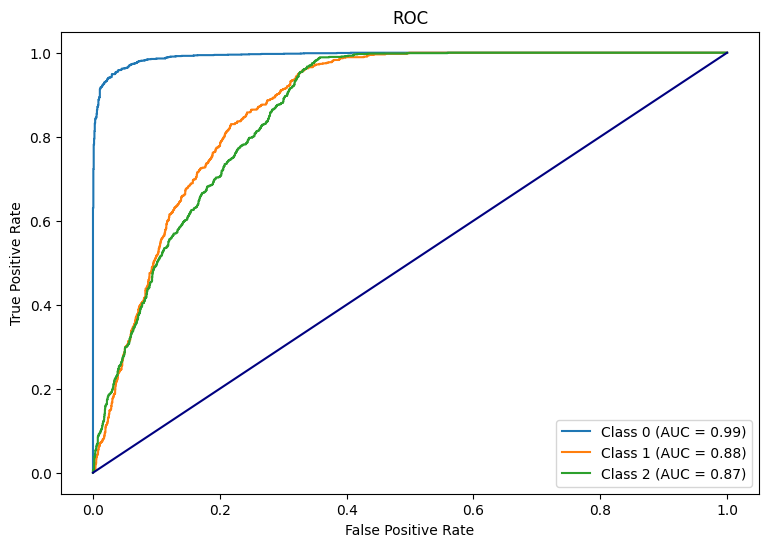

In [8]:


learning_rate = 0.03
epochs = 10

model = Model(CategoricalCrossEntropy(), learning_rate=learning_rate, epochs=epochs)
model.add_lay(LSTM(input_size=x_train.shape[-1], output_size=24, return_sequence=True))
model.add_lay(LSTM(input_size=24, output_size=16, return_sequence=False))
model.add_lay(DenseLay(16, 3, activation='softmax'))
model.train(x_train, y_train, learning_rate=learning_rate, epochs=epochs)

y_pred = model.predict(x_test)

plot_roc_auc(y_test_r, y_pred_r)

Load class 0         Precision:0.9092     Recall:0.9914    
Load class 1         Precision:0.6549     Recall:0.6627    
Load class 2         Precision:0.7237     Recall:0.6032    
F1 mean score: 0.755077839590795


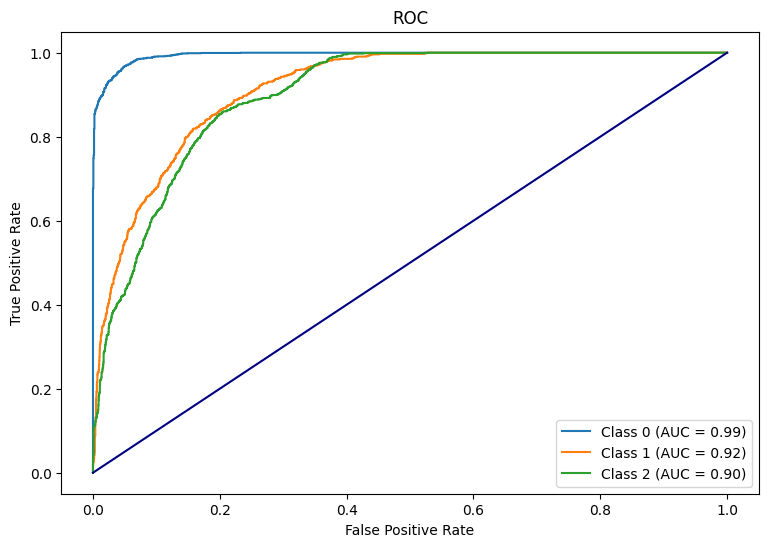

In [9]:


learning_rate = 0.03
epochs = 10

model = Model(CategoricalCrossEntropy(), learning_rate=learning_rate, epochs=epochs)
model.add_lay(GRU(input_size=x_train.shape[-1],output_size=32, return_sequence=True))
model.add_lay(GRU(input_size=32, output_size=12, return_sequence=False))
model.add_lay(DenseLay(12, 3, activation='softmax'))
model.train(x_train, y_train, learning_rate=learning_rate, epochs=epochs)

y_pred = model.predict(x_test)

plot_roc_auc(y_test, y_pred)